# Installing necessary dependencies and project set-up.

In [77]:
# Install required packages
!pip install torch torchvision timm transformers matplotlib scikit-learn opencv-python pandas seaborn umap-learn Pillow fontTools beautifulsoup4 requests tqdm

# Import necessary libraries
import os
import cv2
import torch
import timm
import random
import base64
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from datetime import datetime
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from google.colab import drive, files

from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split

from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageEnhance, ImageOps
from fontTools.ttLib import TTFont

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity

from timm.data import resolve_data_config
from timm.loss import LabelSmoothingCrossEntropy

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mount Google Drive to access your dataset
drive.mount('/content/drive')


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Step 2: Data Loading and Preprocessing Functions**

Indus Dataset

In [ ]:
# Ensure directory exists
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Set output directory in Google Drive
output_dir = "/content/drive/MyDrive/script_analysis/indus"
ensure_dir(output_dir)

print("Please upload the Indus sign list HTML file:")
uploaded = files.upload()

html_file_path = list(uploaded.keys())[0]
print(f"Processing file: {html_file_path}")

base_url = "https://www.indus.epigraphica.de/"

AUTH_USERNAME = "icit"
AUTH_PASSWORD = "seal123"
AUTH_HEADER = {
    "Authorization": "Basic " + base64.b64encode(f"{AUTH_USERNAME}:{AUTH_PASSWORD}".encode()).decode()
}

# Read the HTML file
with open(html_file_path, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "html.parser")

# Find all table rows (skip the header)
rows = soup.find_all("tr")[1:]

# Collect sign data
sign_data = []
for row in rows:
    cols = row.find_all("td")

    if len(cols) < 12:
        continue  # Skip malformed rows

    # Extract sign code (1st column)
    sign_code = cols[0].text.strip()

    # Extract image source (7th column)
    img_tag = cols[6].find("img")
    if img_tag:
        img_src = img_tag["src"]
        img_url = base_url + img_src  # Construct full image URL

        # Extract frequency (12th column)
        try:
            frequency = int(cols[11].text.strip())
        except ValueError:
            continue  # Skip invalid frequency values

        # Store only if frequency > 2
        if frequency > 2:
            sign_data.append((sign_code, img_url))

# Download images with a progress bar
print(f"Downloading {len(sign_data)} images...")

session = requests.Session()
session.headers.update(AUTH_HEADER)  # Add Basic Auth header to all requests

for sign_code, img_url in tqdm(sign_data, desc="Downloading"):
    img_filename = os.path.join(output_dir, f"{sign_code}.jpg")

    response = session.get(img_url, stream=True)
    if response.status_code == 200:
        with open(img_filename, "wb") as img_file:
            img_file.write(response.content)
    else:
        print(f"Failed to download: {img_url} - Status {response.status_code}")

print("Download complete! All images are saved in:", output_dir)


Please upload the Indus sign list HTML file:


Saving ICIT.html to ICIT (5).html
Processing file: ICIT (5).html


Downloading:   0%|          | 0/391 [00:00<?, ?it/s]

Download complete! All images are saved in: /content/drive/MyDrive/script_analysis/indus


Proto-Cuneiform Dataset

In [ ]:
!git clone https://github.com/cdli-gh/proto-cuneiform_signs.git
!mkdir -p /content/drive/MyDrive/script_analysis/proto_cuneiform/
!cp proto-cuneiform_signs/archsigns/*.jpg /content/drive/MyDrive/script_analysis/proto_cuneiform/

Proto-Elamite Dataset

In [ ]:
!git clone https://github.com/sfu-natlang/pe-decipher-toolkit.git
!mkdir -p /content/drive/MyDrive/script_analysis/proto_elamite/
!cp pe-decipher-toolkit/pngs/PE_mainforms/*.png /content/drive/MyDrive/script_analysis/proto_elamite/
!cp pe-decipher-toolkit/pngs/PE_num/*.png /content/drive/MyDrive/script_analysis/proto_elamite/

Naxi Dongba Dataset

Font loaded successfully: BabelStoneNaxiLLC.ttf
Will generate images for 2122 characters (U+E000 to U+E849)


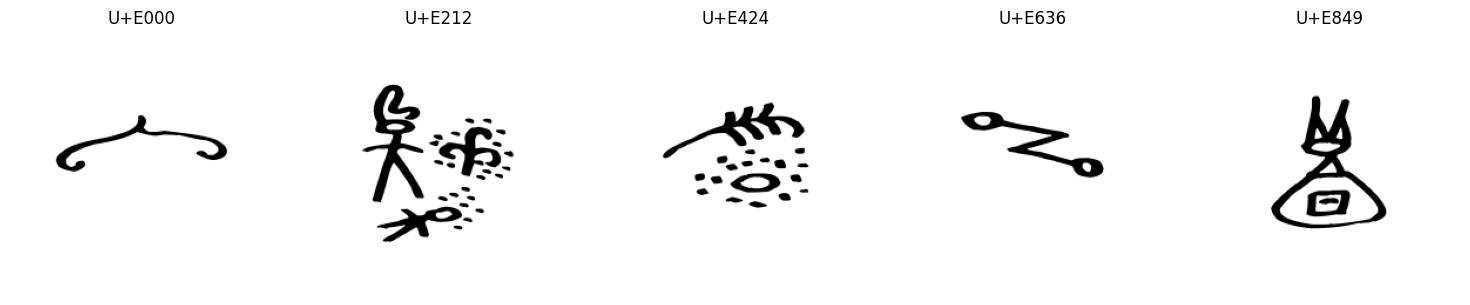

Do the sample characters look correct? (y/n): y


Generating images:   0%|          | 0/2122 [00:00<?, ?it/s]

Created 2122 character images in /content/drive/MyDrive/script_analysis/naxi_dongba/


'/content/drive/MyDrive/script_analysis/naxi_dongba/'

In [ ]:
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def char_to_image(char, font, image_size=224, bg_color=(255, 255, 255), text_color=(0, 0, 0)):
    img = Image.new('RGB', (image_size, image_size), color=bg_color)
    draw = ImageDraw.Draw(img)

    left, top, right, bottom = font.getbbox(char)
    text_width = right - left
    text_height = bottom - top

    # center text
    position = ((image_size - text_width) // 2 - left, (image_size - text_height) // 2 - top)

    draw.text(position, char, fill=text_color, font=font)

    return img

# set range within Dongba font
def create_dongba_dataset(font_path, output_dir, start_code=0xE000, end_code=0xE849, image_size=224):
    ensure_dir(output_dir)

    font_size = int(image_size * 0.7)
    try:
        font = ImageFont.truetype(font_path, font_size)
        print(f"Font loaded successfully: {font_path}")
    except Exception as e:
        print(f"Error loading font {font_path}: {e}")
        return

    char_list = [chr(code) for code in range(start_code, end_code + 1)]
    print(f"Will generate images for {len(char_list)} characters (U+{start_code:04X} to U+{end_code:04X})")

    # Get font name for naming files
    font_name = os.path.splitext(os.path.basename(font_path))[0]

    # Display a few sample characters
    plt.figure(figsize=(15, 3))
    sample_indices = np.linspace(0, len(char_list)-1, 5, dtype=int)

    for i, idx in enumerate(sample_indices):
        char = char_list[idx]
        img = char_to_image(char, font, image_size=image_size)
        plt.subplot(1, 5, i+1)
        plt.imshow(np.array(img))
        plt.title(f"U+{ord(char):04X}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Confirm to proceed
    proceed = input("Do the sample characters look correct? (y/n): ")
    if proceed.lower() != 'y':
        print("Operation cancelled.")
        return

    # Create an image for each character with a progress bar
    for i, char in tqdm(enumerate(char_list), total=len(char_list), desc="Generating images"):
        try:
            # Generate a safe filename
            char_code = f"{ord(char):04X}"
            filename = f"dongba_{char_code}.png"

            # Render the character
            img = char_to_image(char, font, image_size=image_size)

            # Save the image
            img.save(os.path.join(output_dir, filename))

        except Exception as e:
            print(f"Error processing character U+{ord(char):04X}: {e}")

    print(f"Created {len(char_list)} character images in {output_dir}")
    return output_dir

# Set output directory in your Google Drive
output_dir = '/content/drive/MyDrive/script_analysis/naxi_dongba/'

# Create the dataset with the specified Unicode range (U+E000 to U+E849)
create_dongba_dataset(
    font_path="BabelStoneNaxiLLC.ttf",
    output_dir=output_dir,
    start_code=0xE000,
    end_code=0xE849,
    image_size=224
)

Old Naxi dataset

In [39]:
!git clone https://github.com/infinite-hwb/VGTS.git
!mkdir -p /content/drive/MyDrive/script_analysis/old_naxi/
!cp VGTS/"DATA/DBH dataset"/"support image gallery/images"/*.jpg /content/drive/MyDrive/script_analysis/old_naxi/

TYC dataset

Load all datasets. Preprocessing (pad to square and denoise older Naxi glyphs)

Indus dataset: 391 images found
Visualizing preprocessing for a sample from Indus


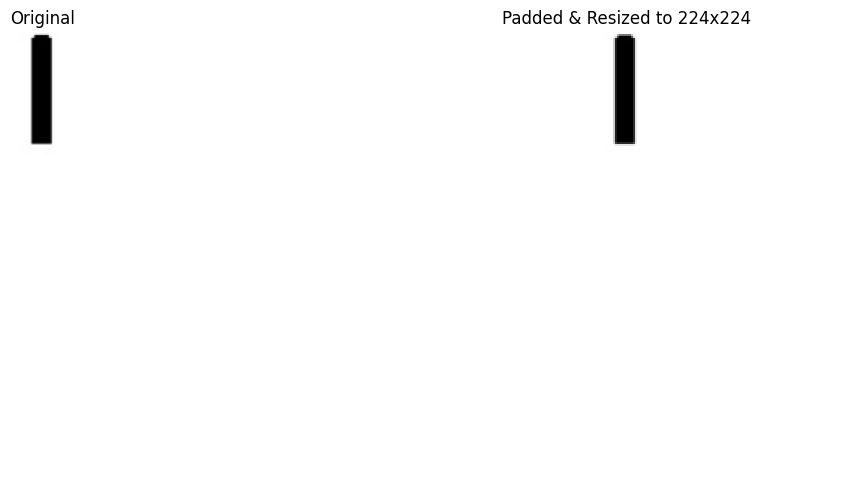

Successfully loaded a batch: shape=torch.Size([1, 3, 224, 224])
Proto-Cuneiform dataset: 2089 images found
Visualizing preprocessing for a sample from Proto-Cuneiform


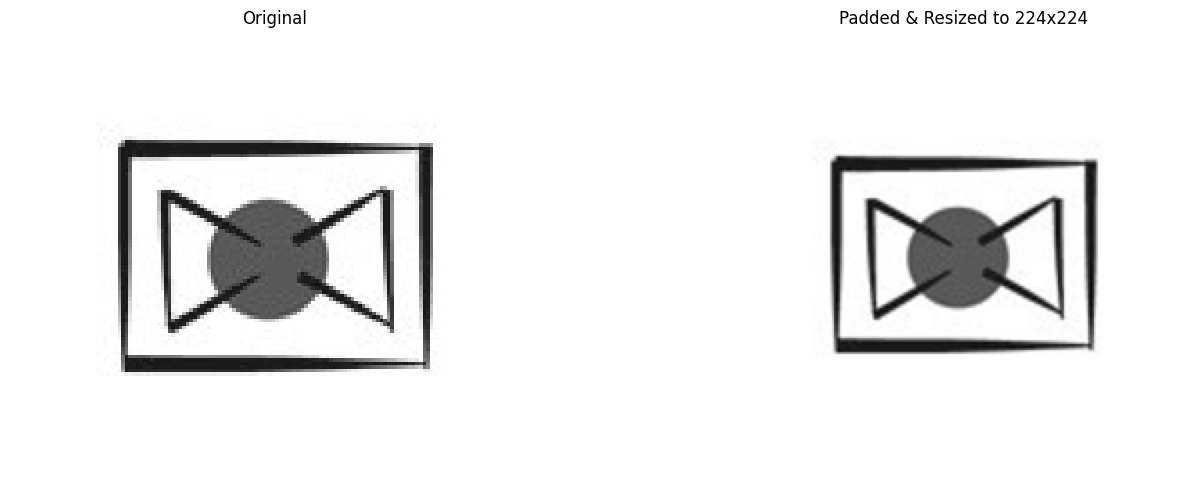

Successfully loaded a batch: shape=torch.Size([1, 3, 224, 224])
Proto-Elamite dataset: 1510 images found
Visualizing preprocessing for a sample from Proto-Elamite


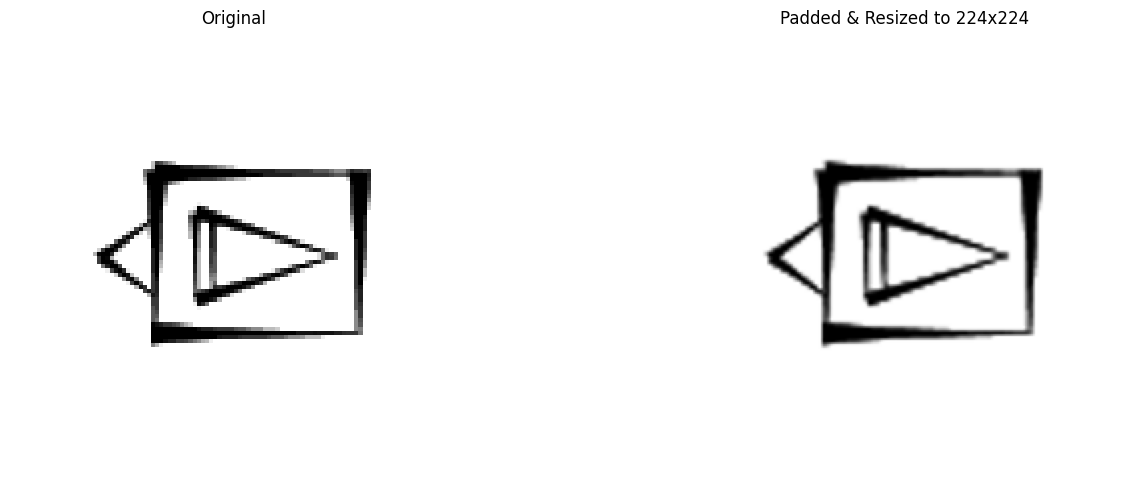

Successfully loaded a batch: shape=torch.Size([1, 3, 224, 224])
Naxi Dongba dataset: 2122 images found
Visualizing preprocessing for a sample from Naxi Dongba


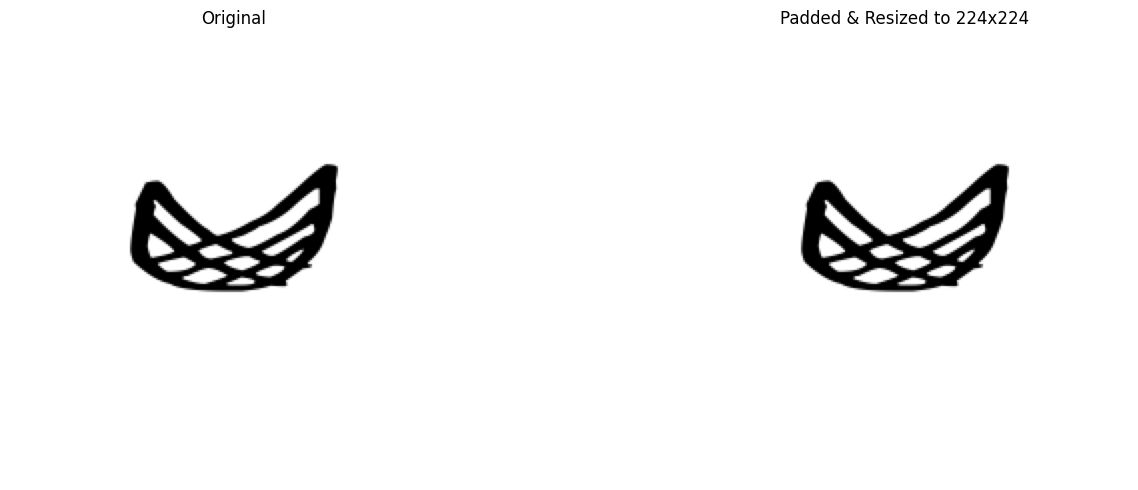

Successfully loaded a batch: shape=torch.Size([1, 3, 224, 224])
Old Naxi dataset: 253 images found
Visualizing preprocessing for a sample from Old Naxi


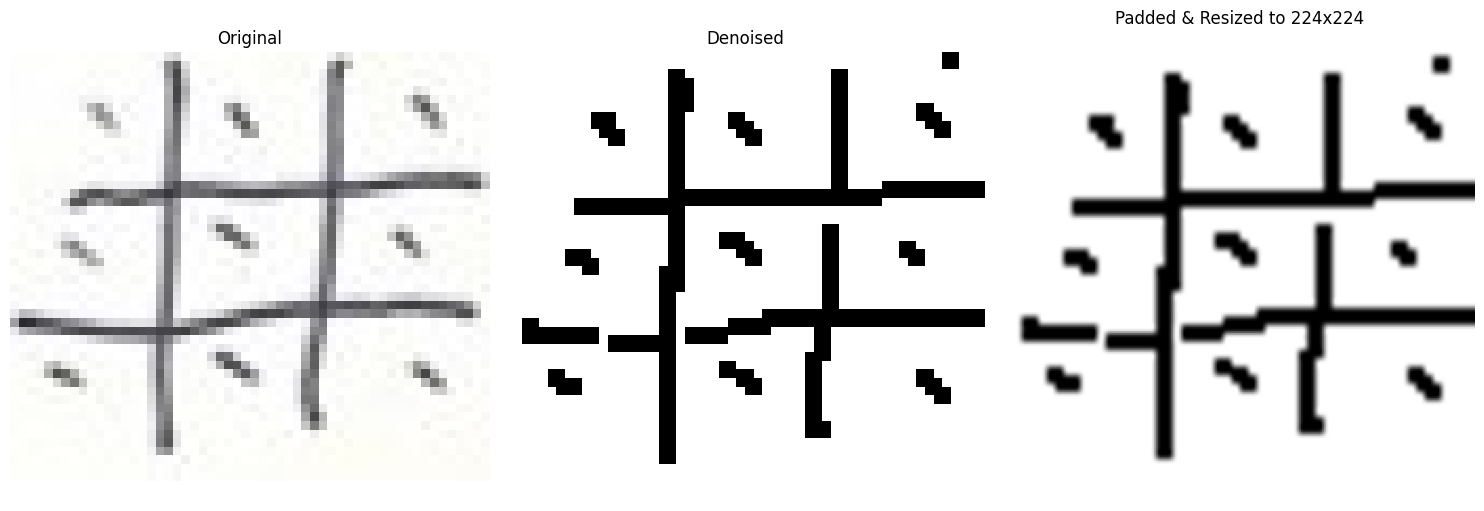

Successfully loaded a batch: shape=torch.Size([1, 3, 224, 224])
Creating combined dataloader with selective denoising (only old Naxi)...
Combined dataloader created with 6365 total images


In [53]:
# Set up paths to your datasets
INDUS_PATH = '/content/drive/MyDrive/script_analysis/indus/'
PROTO_CUNEIFORM_PATH = '/content/drive/MyDrive/script_analysis/proto_cuneiform/'
PROTO_ELAMITE_PATH = '/content/drive/MyDrive/script_analysis/proto_elamite/'
NAXI_DONGBA_PATH = '/content/drive/MyDrive/script_analysis/naxi_dongba/'
OLD_NAXI_PATH = '/content/drive/MyDrive/script_analysis/old_naxi/'

class ScriptDataset(Dataset):
    def __init__(self, image_paths, transform=None, script_type=None, denoise_types=None):
        self.image_paths = image_paths
        self.transform = transform
        self.script_type = script_type
        # Set which script types should be denoised
        self.denoise_types = denoise_types or []

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        try:
            # Load image and convert to RGB
            image = Image.open(image_path).convert('RGB')

            # Apply denoising if this script type is in the denoise_types list
            if self.script_type in self.denoise_types:
                image = denoise_image(image)

            # Apply preprocessing
            if self.transform:
                image = self.transform(image)

            # Return image and script type (if provided)
            if self.script_type is not None:
                return image, self.script_type
            return image

        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            # Return a placeholder in case of error
            if self.transform:
                placeholder = torch.zeros((3, 224, 224))
                if self.script_type is not None:
                    return placeholder, self.script_type
                return placeholder
            else:
                placeholder = Image.new('RGB', (224, 224), color='white')
                if self.script_type is not None:
                    return placeholder, self.script_type
                return placeholder

def denoise_image(image):
    """
    Apply denoising to the image.
    This function combines multiple methods to handle different types of noise.
    """
    # Convert PIL to numpy for OpenCV operations
    np_image = np.array(image)

    # Convert to grayscale if it's a color image (for processing)
    is_color = len(np_image.shape) == 3 and np_image.shape[2] == 3
    if is_color:
        gray = cv2.cvtColor(np_image, cv2.COLOR_RGB2GRAY)
    else:
        gray = np_image.copy()

    # Apply adaptive thresholding to handle uneven lighting (for binary glyph images)
    # This works well for scripts carved or written on varied surfaces
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )

    # Apply morphological operations to remove small noise
    kernel = np.ones((2, 2), np.uint8)
    morphed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Apply non-local means denoising (better preserves edges than Gaussian)
    denoised = cv2.fastNlMeansDenoising(morphed, None, 10, 7, 21)

    # Convert back to original format
    if is_color:
        # Create a 3-channel image from the denoised grayscale
        result = np.stack([denoised] * 3, axis=2)
    else:
        result = denoised

    return Image.fromarray(result)

def pad_to_square(image, background_color='white'):
    """
    Custom function to pad an image to square without distortion.
    Uses white background (or specified color) instead of black.
    """
    # Convert PIL to numpy if needed
    if isinstance(image, Image.Image):
        np_image = np.array(image)
    else:
        np_image = image

    height, width = np_image.shape[:2]

    # Determine the size of the square (max of height and width)
    size = max(height, width)

    # Create a square canvas with white background
    if len(np_image.shape) == 3:  # Color image
        if background_color == 'white':
            square = np.ones((size, size, 3), dtype=np.uint8) * 255
        else:
            square = np.zeros((size, size, 3), dtype=np.uint8)
    else:  # Grayscale
        if background_color == 'white':
            square = np.ones((size, size), dtype=np.uint8) * 255
        else:
            square = np.zeros((size, size), dtype=np.uint8)

    # Calculate padding to center the image
    pad_height = (size - height) // 2
    pad_width = (size - width) // 2

    # Place the original image in the center of the square
    if len(np_image.shape) == 3:  # Color image
        square[pad_height:pad_height+height, pad_width:pad_width+width, :] = np_image
    else:  # Grayscale
        square[pad_height:pad_height+height, pad_width:pad_width+width] = np_image

    # Convert back to PIL if input was PIL
    if isinstance(image, Image.Image):
        return Image.fromarray(square)
    return square

class SquarePad:
    """
    Custom transform to pad images to square while preserving aspect ratio.
    """
    def __init__(self, background_color='white'):
        self.background_color = background_color

    def __call__(self, image):
        return pad_to_square(image, self.background_color)

def get_train_transforms(img_size=224, background_color='white'):
    """
    Returns transforms for training images optimized for Swin Transformer.
    No augmentation as requested.
    """
    return T.Compose([
        SquarePad(background_color),  # Pad to square first
        T.Resize(img_size),  # Then resize
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_test_transforms(img_size=224, background_color='white'):
    """
    Returns transforms for validation/test images optimized for Swin Transformer.
    """
    return T.Compose([
        SquarePad(background_color),  # Pad to square first
        T.Resize(img_size),  # Then resize
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Function to load image paths from a directory
def load_image_paths(directory):
    """
    Loads all valid image paths from a directory recursively.
    """
    image_paths = []
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']

    if not os.path.exists(directory):
        print(f"Warning: Directory {directory} does not exist!")
        return image_paths

    for root, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in valid_extensions):
                image_paths.append(os.path.join(root, file))

    return image_paths

# Create datasets and dataloaders
def create_dataloader(directory, transform, batch_size=32, script_type=None, shuffle=True, denoise_types=None):
    """
    Creates a DataLoader for a given directory of images.

    Args:
        directory: Path to image directory
        transform: Transforms to apply to images
        batch_size: Batch size for DataLoader
        script_type: Label for the script type
        shuffle: Whether to shuffle the data
        denoise_types: List of script types to apply denoising to
    """
    image_paths = load_image_paths(directory)

    if len(image_paths) == 0:
        print(f"Warning: No images found in {directory}")

    dataset = ScriptDataset(image_paths, transform, script_type, denoise_types=denoise_types)

    # Use fewer workers for Colab compatibility
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=2,  # Adjusted for Colab
        pin_memory=True
    )

def visualize_preprocessing(image_path, img_size=224, apply_denoise=False):
    """
    Visualizes the steps of preprocessing to verify the glyph is properly handled.
    """
    # Load original image
    original = Image.open(image_path).convert('RGB')

    # Apply denoising if enabled
    if apply_denoise:
        denoised = denoise_image(original)
        # Apply square padding
        padded = pad_to_square(denoised, 'white')
    else:
        # Apply square padding
        padded = pad_to_square(original, 'white')

    # Resize
    resized = padded.resize((img_size, img_size))

    # Display all steps
    fig, axes = plt.subplots(1, 3 if apply_denoise else 2, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[0].axis('off')

    if apply_denoise:
        axes[1].imshow(denoised, cmap='gray')
        axes[1].set_title("Denoised")
        axes[1].axis('off')

        axes[2].imshow(resized)
        axes[2].set_title(f"Padded & Resized to {img_size}x{img_size}")
        axes[2].axis('off')
    else:
        axes[1].imshow(resized)
        axes[1].set_title(f"Padded & Resized to {img_size}x{img_size}")
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Verify that we can load the datasets and check preprocessing
def check_dataset(path, dataset_name, apply_denoise=False):
    """
    Checks that a dataset can be loaded and visualizes a sample with preprocessing.
    """
    paths = load_image_paths(path)
    print(f"{dataset_name} dataset: {len(paths)} images found")

    if len(paths) > 0:
        # Display original and preprocessed images
        print(f"Visualizing preprocessing for a sample from {dataset_name}")
        visualize_preprocessing(paths[0], apply_denoise=apply_denoise)

        # Test with DataLoader to verify everything works end-to-end
        transform = get_test_transforms(background_color='white')

        # Only apply denoising to specified scripts
        denoise_types = ["Old Naxi"] if apply_denoise else []

        loader = create_dataloader(
            path,
            transform,
            batch_size=1,
            script_type=dataset_name,
            denoise_types=denoise_types
        )

        # Load one batch
        try:
            sample, label = next(iter(loader))
            print(f"Successfully loaded a batch: shape={sample.shape}")
        except Exception as e:
            print(f"Error loading batch: {e}")
    else:
        print(f"No images found in {path}")

def check_all_datasets():
    # Check preprocessing on each dataset
    # Only apply denoising to Old Naxi
    check_dataset(INDUS_PATH, "Indus", apply_denoise=False)
    check_dataset(PROTO_CUNEIFORM_PATH, "Proto-Cuneiform", apply_denoise=False)
    check_dataset(PROTO_ELAMITE_PATH, "Proto-Elamite", apply_denoise=False)
    check_dataset(NAXI_DONGBA_PATH, "Naxi Dongba", apply_denoise=False)
    check_dataset(OLD_NAXI_PATH, "Old Naxi", apply_denoise=True)

# Create a combined dataloader for all script types with selective denoising
def create_combined_dataloader(batch_size=32, img_size=224, shuffle=True):
    """
    Creates a combined dataloader for all script types.
    Only applies denoising to Old Naxi.
    """
    transform = get_train_transforms(img_size=img_size)

    # List of script types to denoise
    denoise_types = ["Old Naxi"]

    datasets = []

    # Create dataset for each script type
    if os.path.exists(INDUS_PATH):
        indus_paths = load_image_paths(INDUS_PATH)
        if indus_paths:
            datasets.append(ScriptDataset(indus_paths, transform, "Indus", denoise_types))

    if os.path.exists(PROTO_CUNEIFORM_PATH):
        cuneiform_paths = load_image_paths(PROTO_CUNEIFORM_PATH)
        if cuneiform_paths:
            datasets.append(ScriptDataset(cuneiform_paths, transform, "Proto-Cuneiform", denoise_types))

    if os.path.exists(PROTO_ELAMITE_PATH):
        elamite_paths = load_image_paths(PROTO_ELAMITE_PATH)
        if elamite_paths:
            datasets.append(ScriptDataset(elamite_paths, transform, "Proto-Elamite", denoise_types))

    if os.path.exists(NAXI_DONGBA_PATH):
        dongba_paths = load_image_paths(NAXI_DONGBA_PATH)
        if dongba_paths:
            datasets.append(ScriptDataset(dongba_paths, transform, "Naxi Dongba", denoise_types))

    if os.path.exists(OLD_NAXI_PATH):
        old_naxi_paths = load_image_paths(OLD_NAXI_PATH)
        if old_naxi_paths:
            datasets.append(ScriptDataset(old_naxi_paths, transform, "Old Naxi", denoise_types))

    # Combine all datasets
    combined_dataset = torch.utils.data.ConcatDataset(datasets)

    return DataLoader(
        combined_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=2,
        pin_memory=True
    )

# Run the dataset checker
check_all_datasets()

# Example: Create a combined dataloader with selective denoising
print("Creating combined dataloader with selective denoising (only old Naxi)...")
combined_loader = create_combined_dataloader(batch_size=16)
print(f"Combined dataloader created with {len(combined_loader.dataset)} total images")

**Data augmentation**

Creating in-memory augmented datasets...
Created dataset for Indus: 391 original images + 1564 augmentations
Created dataset for Proto-Cuneiform: 2089 original images + 8356 augmentations
Created dataset for Proto-Elamite: 1510 original images + 6040 augmentations

Augmented dataset statistics:
- Total images: 22325
- Batch size: 32
- Batches per epoch: 698

Visualizing Indus script augmentations:


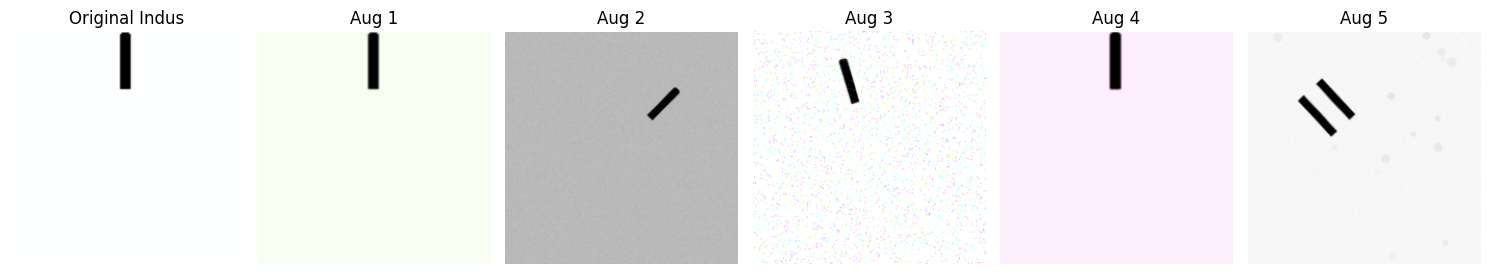


Visualizing Proto-Cuneiform augmentations:


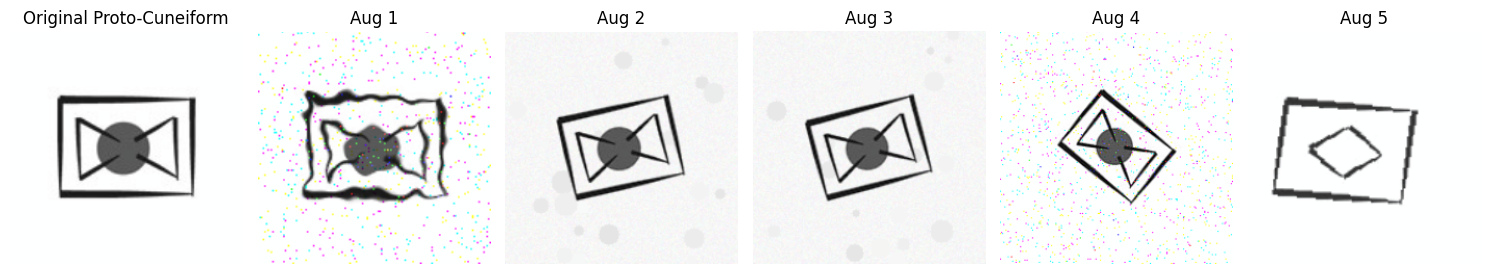


Visualizing Proto-Elamite augmentations:


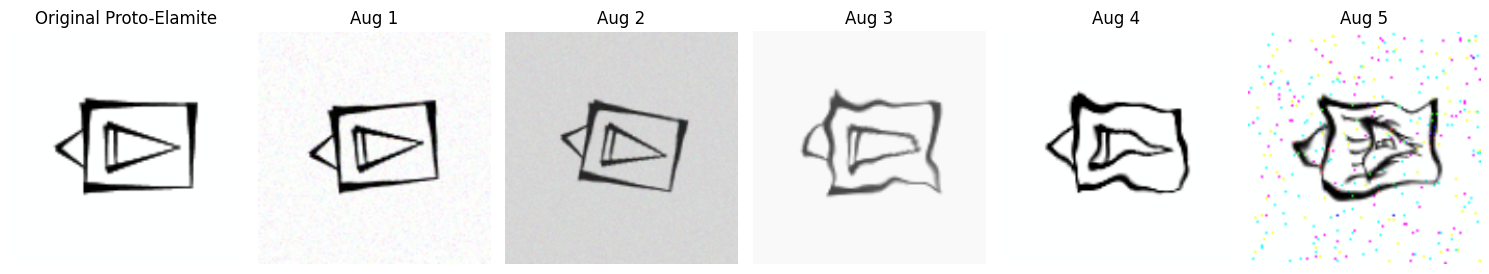

In [76]:
class AugmentationPipeline:
    """Class for generating more intense augmentations while preserving glyph structure"""

    def __init__(self):
        # Define ranges for augmentation parameters - more intense
        self.rotation_range = (-45, 45)  # More rotation but not 180°
        self.brightness_range = (0.7, 1.5)  # More extreme brightness
        self.contrast_range = (0.7, 1.5)  # More extreme contrast
        self.sharpness_range = (0.7, 1.6)  # More extreme sharpness
        self.noise_range = (0.01, 0.05)  # Increased noise range
        self.blur_range = (0.5, 1.2)  # Increased blur range
        self.scale_range = (0.85, 1.15)  # Scale variation

    def rotate(self, image):
        """Apply rotation with white background - more extreme rotation"""
        angle = random.uniform(*self.rotation_range)

        # Convert to RGBA to handle transparency during rotation
        rgba = image.convert('RGBA')

        # Rotate with expand=True to avoid cropping
        rotated = rgba.rotate(angle, resample=Image.BICUBIC, expand=True)

        # Create a new white background image of the same size
        white_bg = Image.new('RGBA', rotated.size, (255, 255, 255, 255))

        # Paste rotated image onto white background using alpha compositing
        result = Image.alpha_composite(white_bg, rotated)

        # Convert back to RGB
        return result.convert('RGB')

    def adjust_brightness(self, image):
        """Adjust brightness with more extreme range"""
        factor = random.uniform(*self.brightness_range)
        enhancer = ImageEnhance.Brightness(image)
        return enhancer.enhance(factor)

    def adjust_contrast(self, image):
        """Adjust contrast with more extreme range"""
        factor = random.uniform(*self.contrast_range)
        enhancer = ImageEnhance.Contrast(image)
        return enhancer.enhance(factor)

    def adjust_sharpness(self, image):
        """Adjust sharpness with more extreme range"""
        factor = random.uniform(*self.sharpness_range)
        enhancer = ImageEnhance.Sharpness(image)
        return enhancer.enhance(factor)

    def add_noise(self, image):
        """Add more noticeable noise"""
        noise_factor = random.uniform(*self.noise_range)
        img_array = np.array(image).astype(np.float32)
        noise = np.random.normal(0, noise_factor * 255, img_array.shape)
        noisy_img = np.clip(img_array + noise, 0, 255).astype(np.uint8)
        return Image.fromarray(noisy_img)

    def add_speckle_noise(self, image):
        """Add speckle noise that simulates degradation"""
        img_array = np.array(image)
        row, col, ch = img_array.shape

        # Generate random black and white dots
        speckle = np.random.rand(row, col, ch)
        speckle = (speckle > 0.99) * 255  # 1% of pixels become white dots

        # Generate random black dots
        black_speckle = np.random.rand(row, col, ch)
        black_speckle = (black_speckle > 0.99) * -255  # 1% of pixels become black dots

        # Add both to image
        noisy = img_array + speckle + black_speckle
        return Image.fromarray(np.clip(noisy, 0, 255).astype(np.uint8))

    def blur(self, image):
        """Apply blur with varying intensity"""
        radius = random.uniform(*self.blur_range)
        return image.filter(ImageFilter.GaussianBlur(radius=radius))

    def color_jitter(self, image):
        """Add slight color variation while preserving structure"""
        # Split into channels
        r, g, b = image.split()

        # Apply slight channel-specific adjustments
        channels = []
        for ch in [r, g, b]:
            enhancer = ImageEnhance.Brightness(ch)
            # Vary brightness per channel to create color shifts
            factor = random.uniform(0.9, 1.1)
            channels.append(enhancer.enhance(factor))

        # Combine channels back
        return Image.merge("RGB", channels)

    def add_background_texture(self, image):
        """Add subtle texture to the background"""
        # Create a texture pattern
        texture_size = image.size
        texture = np.zeros(texture_size + (3,), dtype=np.uint8)

        # Generate texture pattern (e.g., noise pattern)
        for ch in range(3):
            texture[:, :, ch] = np.random.randint(240, 255, texture_size)

        # Add some texture patterns
        for _ in range(20):  # Add some random shapes
            x, y = np.random.randint(0, texture_size[0]), np.random.randint(0, texture_size[1])
            radius = np.random.randint(3, 10)
            color = np.random.randint(230, 250)
            cv2.circle(texture, (x, y), radius, (color, color, color), -1)

        # Convert image to numpy array
        img_array = np.array(image)

        # Create mask where original image pixels are not white
        # This preserves the glyph structure
        mask = np.all(img_array > 240, axis=2)

        # Replace white background with texture
        for ch in range(3):
            img_array[:, :, ch][mask] = texture[:, :, ch][mask]

        return Image.fromarray(img_array)

    def slight_affine(self, image):
        """Apply a slight affine transformation with fixed TF.affine call"""
        # Get a small random affine transformation
        angle = random.uniform(-10, 10)
        scale = random.uniform(*self.scale_range)

        # Apply transformation
        width, height = image.size

        # Calculate translation in pixels
        translate_x = int(random.uniform(-0.1, 0.1) * width)
        translate_y = int(random.uniform(-0.1, 0.1) * height)

        # Apply affine transform using torchvision functional
        # Using fill parameter instead of fillcolor (compatibility fix)
        return TF.affine(
            image,
            angle=angle,
            translate=[translate_x, translate_y],
            scale=scale,
            shear=random.uniform(-5, 5),  # Small shear for distortion
            fill=255  # White background (255 for all channels)
        )

    def elastic_transform(self, image, alpha=40, sigma=4):
        """Apply elastic deformation to simulate material warping"""
        img_array = np.array(image)
        shape = img_array.shape[:2]

        # Random displacement fields
        dx = np.random.rand(*shape) * 2 - 1
        dy = np.random.rand(*shape) * 2 - 1

        # Apply Gaussian filter
        dx = cv2.GaussianBlur(dx, (0, 0), sigma) * alpha
        dy = cv2.GaussianBlur(dy, (0, 0), sigma) * alpha

        # Create mesh grid
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))

        # Displacement with bounds checking
        indices_x = np.clip(x + dx, 0, shape[1]-1).astype(np.float32)
        indices_y = np.clip(y + dy, 0, shape[0]-1).astype(np.float32)

        # Apply elastic transform
        distorted = cv2.remap(img_array, indices_x, indices_y,
                             interpolation=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_CONSTANT,
                             borderValue=(255, 255, 255))

        return Image.fromarray(distorted)

    def generate_augmentations(self, image, num_variations=4):
        """Generate multiple augmentations for a single image"""
        augmented_images = []

        # Define different augmentation combinations - more intense
        augmentation_types = [
            # Combination 1: Rotation + brightness + noise
            lambda img: self.add_noise(self.adjust_brightness(self.rotate(img))),

            # Combination 2: Contrast + affine + color jitter
            lambda img: self.color_jitter(self.adjust_contrast(self.slight_affine(img))),

            # Combination 3: Speckle noise + sharpness + rotation
            lambda img: self.adjust_sharpness(self.add_speckle_noise(self.rotate(img))),

            # Combination 4: Elastic transform + contrast
            lambda img: self.adjust_contrast(self.elastic_transform(img)),

            # Combination 5: Background texture + rotation
            lambda img: self.add_background_texture(self.rotate(img)),

            # Combination 6: Intense multiple adjustments
            lambda img: self.add_noise(self.adjust_contrast(
                       self.adjust_brightness(self.rotate(img)))),

            # Combination 7: Blur + contrast + color
            lambda img: self.color_jitter(self.adjust_contrast(self.blur(img))),

            # Combination 8: Elastic + speckle noise
            lambda img: self.add_speckle_noise(self.elastic_transform(img))
        ]

        # Select random augmentations
        selected_augmentations = random.sample(augmentation_types, min(num_variations, len(augmentation_types)))

        # Apply selected augmentations
        for augment_func in selected_augmentations:
            try:
                aug_img = augment_func(image)
                augmented_images.append(aug_img)
            except Exception as e:
                print(f"Augmentation error: {e}")
                # Add original as fallback
                augmented_images.append(image)

            if len(augmented_images) >= num_variations:
                break

        # If we still need more variations, add some basic ones
        while len(augmented_images) < num_variations:
            try:
                # Simple rotation as fallback
                aug_img = self.rotate(image)
                augmented_images.append(aug_img)
            except Exception as e:
                print(f"Fallback augmentation error: {e}")
                augmented_images.append(image)

        return augmented_images

class AugmentedScriptDataset(Dataset):
    """Dataset class that generates augmentations on-the-fly"""

    def __init__(self, image_paths, transform=None, script_type=None,
                 denoise_types=None, augmentations_per_image=4):
        self.original_paths = image_paths
        self.transform = transform
        self.script_type = script_type
        self.denoise_types = denoise_types or []
        self.augmentations_per_image = augmentations_per_image
        self.augmenter = AugmentationPipeline()

        # Calculate total length (original images + augmented images)
        self.total_len = len(self.original_paths) * (1 + augmentations_per_image)

        print(f"Created dataset for {script_type}: {len(self.original_paths)} original images + "
              f"{len(self.original_paths) * augmentations_per_image} augmentations")

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        # Determine if this is an original or augmented image
        original_count = len(self.original_paths)

        if idx < original_count:
            # Return original image
            image_path = self.original_paths[idx]
            try:
                image = Image.open(image_path).convert('RGB')

                # Apply denoising if needed
                if self.script_type in self.denoise_types:
                    image = denoise_image(image)

                # Apply padding to square
                image = pad_to_square(image, 'white')

                # Apply transform
                if self.transform:
                    image = self.transform(image)

                # Return image and script type
                if self.script_type is not None:
                    return image, self.script_type
                return image

            except Exception as e:
                print(f"Error loading {image_path}: {e}")
                placeholder = torch.zeros((3, 224, 224))
                if self.script_type is not None:
                    return placeholder, self.script_type
                return placeholder
        else:
            # Return augmented image
            # Calculate which original image to augment and which variation to use
            original_idx = (idx - original_count) // self.augmentations_per_image
            aug_variation = (idx - original_count) % self.augmentations_per_image

            # Get the original image path
            if original_idx < len(self.original_paths):
                original_path = self.original_paths[original_idx]
            else:
                # Fallback if index out of range
                original_path = self.original_paths[0]

            try:
                # Load original image
                original = Image.open(original_path).convert('RGB')

                # Apply denoising if needed
                if self.script_type in self.denoise_types:
                    original = denoise_image(original)

                # Apply padding to square first
                original = pad_to_square(original, 'white')

                # Generate augmentations for this image
                augmented_images = self.augmenter.generate_augmentations(
                    original, self.augmentations_per_image)

                # Select the specific augmentation variation
                if aug_variation < len(augmented_images):
                    aug_image = augmented_images[aug_variation]
                else:
                    # Fallback if not enough variations were generated
                    aug_image = original

                # Apply transform
                if self.transform:
                    aug_image = self.transform(aug_image)

                # Return augmented image and script type
                if self.script_type is not None:
                    return aug_image, self.script_type
                return aug_image

            except Exception as e:
                print(f"Error processing augmentation for {original_path}: {e}")
                placeholder = torch.zeros((3, 224, 224))
                if self.script_type is not None:
                    return placeholder, self.script_type
                return placeholder

# Create in-memory augmented datasets for the three specified scripts
print("Creating in-memory augmented datasets...")

# Load paths from original datasets
indus_paths = load_image_paths(INDUS_PATH)
cuneiform_paths = load_image_paths(PROTO_CUNEIFORM_PATH)
elamite_paths = load_image_paths(PROTO_ELAMITE_PATH)
dongba_paths = load_image_paths(NAXI_DONGBA_PATH)
old_naxi_paths = load_image_paths(OLD_NAXI_PATH)

# Set transformations
train_transform = get_train_transforms(img_size=224)
test_transform = get_test_transforms(img_size=224)

# Set which script types to denoise (based on original code)
denoise_types = ["Old Naxi"]

# Create augmented datasets with 4 augmentations per original image
indus_dataset = AugmentedScriptDataset(
    indus_paths, train_transform, "Indus", denoise_types, augmentations_per_image=4
)

cuneiform_dataset = AugmentedScriptDataset(
    cuneiform_paths, train_transform, "Proto-Cuneiform", denoise_types, augmentations_per_image=4
)

elamite_dataset = AugmentedScriptDataset(
    elamite_paths, train_transform, "Proto-Elamite", denoise_types, augmentations_per_image=4
)

# Create regular datasets for the others (no augmentation)
dongba_dataset = ScriptDataset(dongba_paths, train_transform, "Naxi Dongba", denoise_types)
old_naxi_dataset = ScriptDataset(old_naxi_paths, train_transform, "Old Naxi", denoise_types)

# Create a combined dataset with all scripts
all_datasets = [
    indus_dataset,
    cuneiform_dataset,
    elamite_dataset,
    dongba_dataset,
    old_naxi_dataset
]

# Remove any empty datasets
all_datasets = [ds for ds in all_datasets if len(ds) > 0]

# Create combined dataset
combined_dataset = ConcatDataset(all_datasets)

# Create dataloaders
batch_size = 32
augmented_train_loader = DataLoader(
    combined_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# Print statistics
print(f"\nAugmented dataset statistics:")
print(f"- Total images: {len(combined_dataset)}")
print(f"- Batch size: {batch_size}")
print(f"- Batches per epoch: {len(augmented_train_loader)}")

# Visualize a few examples from the augmented dataset
def visualize_augmentations(dataset_idx=0, num_augmentations=5):
    """
    Visualize original image and its augmentations

    Args:
        dataset_idx: Index of the dataset in all_datasets list
        num_augmentations: Number of augmentations to show
    """
    if len(all_datasets) <= dataset_idx:
        print("Dataset index out of range")
        return

    dataset = all_datasets[dataset_idx]
    if not hasattr(dataset, 'augmenter'):
        print("Selected dataset does not support augmentation")
        return

    # Get an original image
    original_idx = 0
    original_img, label = dataset[original_idx]

    # Get corresponding augmentations
    augmented_images = []
    aug_start_idx = len(dataset.original_paths)
    for i in range(num_augmentations):
        aug_idx = aug_start_idx + (original_idx * dataset.augmentations_per_image) + i
        if aug_idx < len(dataset):
            aug_img, _ = dataset[aug_idx]
            augmented_images.append(aug_img)

    # Prepare visualization
    plt.figure(figsize=(15, 5))

    # Display original image
    plt.subplot(1, num_augmentations+1, 1)

    # Convert tensor to image
    if isinstance(original_img, torch.Tensor):
        img = original_img.permute(1, 2, 0).numpy()
        # Denormalize
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
    else:
        plt.imshow(np.array(original_img))

    plt.title(f"Original {label}")
    plt.axis('off')

    # Display augmentations
    for i, aug_img in enumerate(augmented_images):
        plt.subplot(1, num_augmentations+1, i+2)

        # Convert tensor to image
        if isinstance(aug_img, torch.Tensor):
            img = aug_img.permute(1, 2, 0).numpy()
            # Denormalize
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            plt.imshow(img)
        else:
            plt.imshow(np.array(aug_img))

        plt.title(f"Aug {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show augmentations for each dataset type
print("\nVisualizing Indus script augmentations:")
visualize_augmentations(dataset_idx=0, num_augmentations=5)

print("\nVisualizing Proto-Cuneiform augmentations:")
visualize_augmentations(dataset_idx=1, num_augmentations=5)

print("\nVisualizing Proto-Elamite augmentations:")
visualize_augmentations(dataset_idx=2, num_augmentations=5)

# Use this dataloader for training
# augmented_train_loader

# Step 3: Training Swin Transformer Models for Ancient Script Analysis

In [ ]:
Set up Swin Transformer.

Training pipeline

Using device: cuda
Starting training for all three script models...

===== Training Indus Model =====

Preparing Indus dataset:
  - Total samples: 391
  - Training samples: 274
  - Validation samples: 78
  - Test samples: 39
Created dataset for Indus: 274 original images + 1096 augmentations


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 [Train]:   0%|          | 0/43 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'float'

Extract feature embeddings from trained models